## Modeling & Prediction

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import datetime
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from matplotlib import pyplot as plt

import warnings
warnings.simplefilter('ignore')

In [88]:
# Load the final cleaned training set to train the classifiers
pd.set_option('display.max_columns', None)

df =pd.read_csv('./assets/train_final.csv')

In [89]:
df.head(5)

,date,species,trap,latitude,longitude,nummosquitos,wnvpresent,year,month,day,day_of_week,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,Tavg_lag_7,PrecipTotal_lag_7,Tavg_lag_10,PrecipTotal_lag_10,Tavg_lag_14,PrecipTotal_lag_14
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0,2007,May,29,Tue,88.0,62.5,75.5,58.5,65.5,0.0,10.5,0.0,29.415,30.1,5.8,17.0,6.95,61.0,0.0,70.0,0.0,68.0,0.0
1,2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,1,0,2007,May,29,Tue,88.0,62.5,75.5,58.5,65.5,0.0,10.5,0.0,29.415,30.1,5.8,17.0,6.95,61.0,0.0,70.0,0.0,68.0,0.0
2,2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,1,0,2007,May,29,Tue,88.0,62.5,75.5,58.5,65.5,0.0,10.5,0.0,29.415,30.1,5.8,17.0,6.95,61.0,0.0,70.0,0.0,68.0,0.0
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0,2007,May,29,Tue,88.0,62.5,75.5,58.5,65.5,0.0,10.5,0.0,29.415,30.1,5.8,17.0,6.95,61.0,0.0,70.0,0.0,68.0,0.0
4,2007-05-29,CULEX RESTUANS,T015,41.974089,-87.824812,4,0,2007,May,29,Tue,88.0,62.5,75.5,58.5,65.5,0.0,10.5,0.0,29.415,30.1,5.8,17.0,6.95,61.0,0.0,70.0,0.0,68.0,0.0


Due the null values in the lag weather columns, we will be removing them since they're mainly from the start of the dataset i.e. May 2007.

In [90]:
df.isnull().sum()

date                    0
species                 0
trap                    0
latitude                0
longitude               0
nummosquitos            0
wnvpresent              0
year                    0
month                   0
day                     0
day_of_week             0
tmax                    0
tmin                    0
tavg                    0
dewpoint                0
wetbulb                 0
heat                    0
cool                    0
preciptotal             0
stnpressure             0
sealevel                0
resultspeed             0
resultdir               0
avgspeed                0
Tavg_lag_7              0
PrecipTotal_lag_7      92
Tavg_lag_10           125
PrecipTotal_lag_10     91
Tavg_lag_14             0
PrecipTotal_lag_14      0
dtype: int64

In [91]:
df.dropna(inplace=True)

We will need to deal with the categorical data such as mosquito species and dates before doing any modeling of the data.

In [92]:
df['species'].value_counts()

CULEX PIPIENS/RESTUANS    4617
CULEX RESTUANS            2713
CULEX PIPIENS             2562
CULEX TERRITANS            218
CULEX SALINARIUS            82
CULEX TARSALIS               5
CULEX ERRATICUS              1
Name: species, dtype: int64

In [93]:
df = pd.concat([df,pd.get_dummies(df['species'], drop_first = False)], axis = 1)
df.drop('species', inplace=True, axis=1)

In [94]:
df.drop('date',axis=1,inplace=True)

In [95]:
df['day_of_week'].value_counts()

Fri    3639
Thu    2576
Wed    1704
Mon    1315
Tue     964
Name: day_of_week, dtype: int64

In [96]:
# Day of the week is too granular and will be dropped
df.drop('day_of_week', inplace=True, axis=1)

In [97]:
df['month'].value_counts()

Aug    3751
Jul    2606
Sep    1910
Jun    1571
Oct     276
May      84
Name: month, dtype: int64

In [98]:
df = pd.concat([df,pd.get_dummies(df['month'], drop_first = False)], axis = 1)
df.drop('month', inplace=True, axis=1)

Trap locations are already represented by the longitudinal & latitude coordinates, hence it will be dropped.

In [99]:
df.drop('trap', axis=1, inplace=True)

In [100]:
df.head(5)

,latitude,longitude,nummosquitos,wnvpresent,year,day,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,Tavg_lag_7,PrecipTotal_lag_7,Tavg_lag_10,PrecipTotal_lag_10,Tavg_lag_14,PrecipTotal_lag_14,CULEX ERRATICUS,CULEX PIPIENS,CULEX PIPIENS/RESTUANS,CULEX RESTUANS,CULEX SALINARIUS,CULEX TARSALIS,CULEX TERRITANS,Aug,Jul,Jun,May,Oct,Sep
0,41.954690,-87.800991,1,0,2007,29,88.0,62.5,75.5,58.5,65.5,0.0,10.5,0.0,29.415,30.1,5.8,17.0,6.95,61.0,0.0,70.0,0.0,68.0,0.0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,41.954690,-87.800991,1,0,2007,29,88.0,62.5,75.5,58.5,65.5,0.0,10.5,0.0,29.415,30.1,5.8,17.0,6.95,61.0,0.0,70.0,0.0,68.0,0.0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,41.994991,-87.769279,1,0,2007,29,88.0,62.5,75.5,58.5,65.5,0.0,10.5,0.0,29.415,30.1,5.8,17.0,6.95,61.0,0.0,70.0,0.0,68.0,0.0,0,0,0,1,0,0,0,0,0,0,1,0,0
3,41.974089,-87.824812,1,0,2007,29,88.0,62.5,75.5,58.5,65.5,0.0,10.5,0.0,29.415,30.1,5.8,17.0,6.95,61.0,0.0,70.0,0.0,68.0,0.0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,41.974089,-87.824812,4,0,2007,29,88.0,62.5,75.5,58.5,65.5,0.0,10.5,0.0,29.415,30.1,5.8,17.0,6.95,61.0,0.0,70.0,0.0,68.0,0.0,0,0,0,1,0,0,0,0,0,0,1,0,0


### Calculating the Baseline

In [101]:
df['wnvpresent'].value_counts()

0    9666
1     532
Name: wnvpresent, dtype: int64

In [102]:
baseline_accuracy = len(df[df['wnvpresent']==0])/len(df['wnvpresent'])

In [103]:
baseline_accuracy

0.9478329084134144

Since this model is heavily skewed (~95%) towards non-WNV present, we would look at ROC & AUC as well as Type 1 & 2 errors to benchmark and select the test model & parameters.

### Pre-Modeling Feature Engineering

In [104]:
# Check train data length
df.shape

(10198, 38)

In [105]:
# run check to check train & test features 
df.columns

Index(['latitude', 'longitude', 'nummosquitos', 'wnvpresent', 'year', 'day',
       'tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool',
       'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir',
       'avgspeed', 'Tavg_lag_7', 'PrecipTotal_lag_7', 'Tavg_lag_10',
       'PrecipTotal_lag_10', 'Tavg_lag_14', 'PrecipTotal_lag_14',
       'CULEX ERRATICUS', 'CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS',
       'CULEX RESTUANS', 'CULEX SALINARIUS', 'CULEX TARSALIS',
       'CULEX TERRITANS', 'Aug', 'Jul', 'Jun', 'May', 'Oct', 'Sep'],
      dtype='object')

For the scope of this project, the prediction of mosquitoe numbers to traps will not be conducted since it also subject to time based variables and spray data which is incomplete for most years. Hence this value should be dropped from modeling. Also, the month of 'May' to be removed as it is not present in test set.

In [106]:
X = df.drop(['wnvpresent','nummosquitos','May'], axis=1)
y = df['wnvpresent']

In [107]:
X.head(2)

,latitude,longitude,year,day,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,Tavg_lag_7,PrecipTotal_lag_7,Tavg_lag_10,PrecipTotal_lag_10,Tavg_lag_14,PrecipTotal_lag_14,CULEX ERRATICUS,CULEX PIPIENS,CULEX PIPIENS/RESTUANS,CULEX RESTUANS,CULEX SALINARIUS,CULEX TARSALIS,CULEX TERRITANS,Aug,Jul,Jun,Oct,Sep
0,41.95469,-87.800991,2007,29,88.0,62.5,75.5,58.5,65.5,0.0,10.5,0.0,29.415,30.1,5.8,17.0,6.95,61.0,0.0,70.0,0.0,68.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0
1,41.95469,-87.800991,2007,29,88.0,62.5,75.5,58.5,65.5,0.0,10.5,0.0,29.415,30.1,5.8,17.0,6.95,61.0,0.0,70.0,0.0,68.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0


### Test/ Train Split

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

For the purposes of this project, 3 classification methods used to derive the best model.
Hence the following testing steps will be performed in this sequence:

<ul>
    <li>Logistic Regression Classifer</li>    
    <li>K_Nearest Neighbours Classifier</li> 
    <li>Random Forest Classifer</li> 
</ul>

<b>GridSearchCV</b> will be used to perform hyper parameter tuning in order to determine the optimal values for a given model. 

### Logistic Regression (without GridSearch)

In [23]:
lr = LogisticRegression()

In [24]:
pipe_lr  = Pipeline([('std', StandardScaler()),
                     ('lr', lr)])

In [25]:
pipe_lr.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('std',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [26]:
print(pipe_lr.score(X_train,y_train))
print(pipe_lr.score(X_test,y_test))

0.948394214268203
0.9480392156862745


In [27]:
y_pred_lr = pipe_lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1934
           1       0.00      0.00      0.00       106

    accuracy                           0.95      2040
   macro avg       0.47      0.50      0.49      2040
weighted avg       0.90      0.95      0.92      2040



In [28]:
pd.DataFrame(confusion_matrix(y_test, y_pred_lr),columns=['Predict: No', 'Predict: Yes'], index=['Actual: No', 'Actual: Yes'])

,Predict: No,Predict: Yes
Actual: No,1934,0
Actual: Yes,106,0


In [29]:
lr_proba = pipe_lr.predict_proba(X_test)
lr_probability = [i[1] for i in lr_proba]
roc_auc_score(y_test, lr_probability)

0.8386933913484615

### Logistic Regression (with GridSearch)

In [31]:
param_grid_lr  = [{'lr__penalty': ['l1','l2'],
                   'lr__solver':['liblinear'],
                   'lr__C': np.logspace(-5,0,100)}]

grid_lr = GridSearchCV(pipe_lr,param_grid=param_grid_lr,scoring='roc_auc',cv=5, verbose = 1, n_jobs=-1)
grid_lr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 985 out of 1000 | elapsed:   13.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   14.2s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('std',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('lr',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='auto',
                 

In [32]:
# Training data without cross-validation
grid_lr.score(X_train, y_train)

0.8245708949333178

In [33]:
# Score it on the testing data
grid_lr.score(X_test, y_test)

0.8370348871241537

There seems to be less overfitting as compared to the logistic without hyper-parameter tuning

In [34]:
# best score on the training data which has undergone cross-validation
grid_lr.best_score_ 

0.8139479516548545

In [35]:
# best parameters on the training data
grid_lr.best_params_

{'lr__C': 0.7054802310718645, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}

Lasso regression seems to work best for the logistic model.

In [36]:
# Retrieve the best hyperparameters values and retrain the model
best_lr = grid_lr.best_estimator_
best_lr.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('std',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('lr',
                 LogisticRegression(C=0.7054802310718645, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=100, multi_class='auto',
                                    n_jobs=None, penalty='l1',
                                    random_state=None, solver='liblinear',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)

In [37]:
# Perform prediction on the validation model

lr_y_pred = best_lr.predict(X_test)
print(classification_report(y_test, lr_y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1934
           1       0.00      0.00      0.00       106

    accuracy                           0.95      2040
   macro avg       0.47      0.50      0.49      2040
weighted avg       0.90      0.95      0.92      2040



In [38]:
pd.DataFrame(confusion_matrix(y_test, lr_y_pred),columns=['Predict: No', 'Predict: Yes'], index=['Actual: No', 'Actual: Yes'])

,Predict: No,Predict: Yes
Actual: No,1934,0
Actual: Yes,106,0


In [39]:
tn, fp, fn, tp = confusion_matrix(y_test, lr_y_pred).ravel()

In [40]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 1934
False Positives: 0
False Negatives: 106
True Positives: 0


In [41]:
# Generate the new roc_auc score for logistic regression based on the optimized parameters

lr_proba_gs = best_lr.predict_proba(X_test)
lr_probability_gs = [i[1] for i in lr_proba_gs]
roc_auc_score(y_test, lr_probability_gs)

0.8370348871241537

### ROC Curve

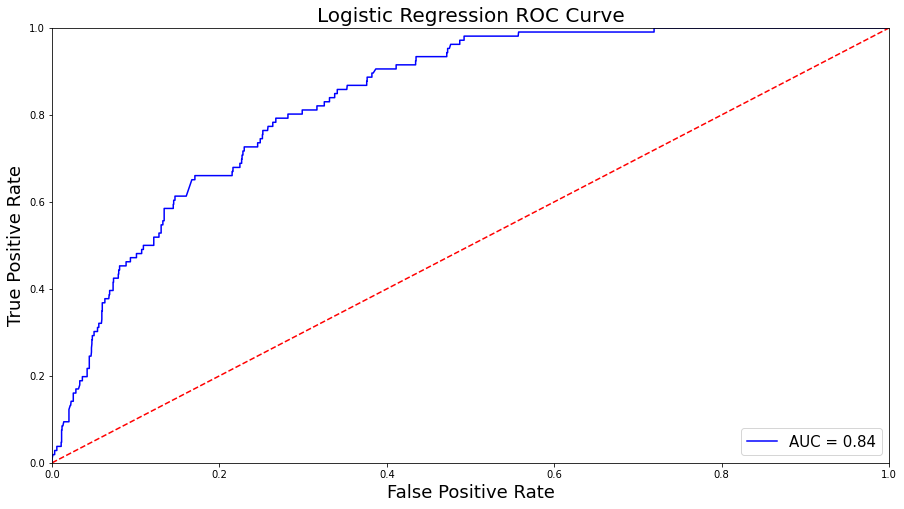

In [42]:
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test,lr_probability_gs)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
plt.title('Logistic Regression ROC Curve', fontsize=20)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right', fontsize=15)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=18)
plt.xlabel('False Positive Rate', fontsize=18)
plt.show()

### K-Nearest Neighbours (using GridSearch)

In [43]:
knn = KNeighborsClassifier()

In [44]:
pipe_knn = Pipeline([('std', StandardScaler()),
                     ('knn', knn)])

In [45]:
param_grid_knn = [{'knn__n_neighbors': list(range(1, 10)),
                   'knn__p': [1, 2],
                   'knn__leaf_size': np.arange(10,51,10)}]

grid_knn = GridSearchCV(pipe_knn,param_grid=param_grid_knn,scoring='roc_auc',cv=5, verbose = 1, n_jobs=-1)
grid_knn.fit(X_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  1.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('std',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
             i

In [46]:
grid_knn.score(X_test, y_test)

0.793313788999239

In [47]:
# best score on the training data which has undergone cross-validation
grid_knn.best_score_ 

0.7560761223264463

In [48]:
grid_knn.best_params_

{'knn__leaf_size': 10, 'knn__n_neighbors': 9, 'knn__p': 2}

In [49]:
best_knn = grid_knn.best_estimator_
best_knn.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('std',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=10,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=9, p=2,
                                      weights='uniform'))],
         verbose=False)

In [50]:
knn_y_pred = best_knn.predict(X_test)
print(classification_report(y_test, knn_y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1934
           1       0.60      0.06      0.10       106

    accuracy                           0.95      2040
   macro avg       0.78      0.53      0.54      2040
weighted avg       0.93      0.95      0.93      2040



KNN fares slightly better than the logistic model in precision and recall score for WNV positives.

In [51]:
tn2, fp2, fn2, tp2 = confusion_matrix(y_test, knn_y_pred).ravel()

In [52]:
print("True Negatives: %s" % tn2)
print("False Positives: %s" % fp2)
print("False Negatives: %s" % fn2)
print("True Positives: %s" % tp2)

True Negatives: 1930
False Positives: 4
False Negatives: 100
True Positives: 6


In [53]:
# Confusion Matrix Table
pd.DataFrame(confusion_matrix(y_test, knn_y_pred),columns=['Predict: No', 'Predict: Yes'], index=['Actual: No', 'Actual: Yes'])

,Predict: No,Predict: Yes
Actual: No,1930,4
Actual: Yes,100,6


In [54]:
# Generate the new roc_auc score for random forest based on the optimized parameters

knn_proba_gs = best_knn.predict_proba(X_test)
knn_probability_gs = [i[1] for i in knn_proba_gs]
roc_auc_score(y_test, knn_probability_gs)

0.793313788999239

Even with GridSearch, KNN model has a poorer ability than the logistic model in distinguishing between error classes.

### Random Forest (without GridSearch)

In [55]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [56]:
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1934
           1       0.26      0.08      0.12       106

    accuracy                           0.94      2040
   macro avg       0.60      0.53      0.54      2040
weighted avg       0.92      0.94      0.93      2040



In [57]:
pd.DataFrame(confusion_matrix(y_test, y_pred_rf),columns=['Predict: No', 'Predict: Yes'], index=['Actual: No', 'Actual: Yes'])

,Predict: No,Predict: Yes
Actual: No,1911,23
Actual: Yes,98,8


In [58]:
rf_proba = rf.predict_proba(X_test)
rf_probability = [i[1] for i in rf_proba]
roc_auc_score(y_test, rf_probability)

0.8031111588066574

### Random Forest (with GridSearch)

In [59]:
param_grid_rf  = [{'n_estimators': [100,500,1000],
                   'min_samples_split': [5,10,20,30], 
                   'max_features': ['auto'],
                   'max_depth':[None,1,5,10],
                   'min_samples_leaf': [1],
                   'bootstrap':[True]}] 

grid_rf = GridSearchCV(rf,param_grid=param_grid_rf,scoring='roc_auc',cv=5,verbose = 1, n_jobs=-1)
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  2.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [60]:
# Training data without cross-validation
grid_rf.score(X_train, y_train)

0.9223248180235057

In [61]:
# Score it on the testing data
grid_rf.score(X_test, y_test)

0.8494687908528614

In [62]:
# best score on the training data which has undergone cross-validation
grid_rf.best_score_ 

0.8343970370232704

In [63]:
grid_rf.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 30,
 'n_estimators': 1000}

In [64]:
# Retrieve the best hyperparameters values and retrain the model
best_rf = grid_rf.best_estimator_
best_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=30,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [65]:
gs_y_pred = best_rf.predict(X_test)
print(classification_report(y_test, gs_y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1934
           1       1.00      0.02      0.04       106

    accuracy                           0.95      2040
   macro avg       0.97      0.51      0.51      2040
weighted avg       0.95      0.95      0.93      2040



In [66]:
tn3, fp3, fn3, tp3 = confusion_matrix(y_test, gs_y_pred).ravel()

In [67]:
print("True Negatives: %s" % tn3)
print("False Positives: %s" % fp3)
print("False Negatives: %s" % fn3)
print("True Positives: %s" % tp3)

True Negatives: 1934
False Positives: 0
False Negatives: 104
True Positives: 2


In [68]:
# Confusion Matrix Table
pd.DataFrame(confusion_matrix(y_test, gs_y_pred),columns=['Predict: No', 'Predict: Yes'], index=['Actual: No', 'Actual: Yes'])

,Predict: No,Predict: Yes
Actual: No,1934,0
Actual: Yes,104,2


In [69]:
# Generate the new roc_auc score for random forest based on the optimized parameters

rf_proba_gs = best_rf.predict_proba(X_test)
rf_probability_gs = [i[1] for i in rf_proba_gs]
roc_auc_score(y_test, rf_probability_gs)

0.8489858734463718

### Random Forest ROC Curve

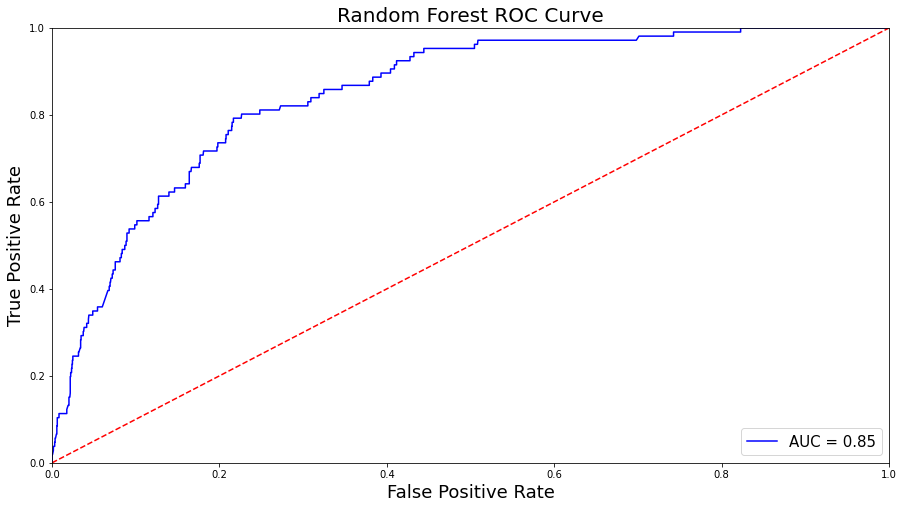

In [70]:
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test,rf_probability_gs)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(15,8))
plt.title('Random Forest ROC Curve', fontsize=20)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right', fontsize=15)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=18)
plt.xlabel('False Positive Rate', fontsize=18)
plt.show()

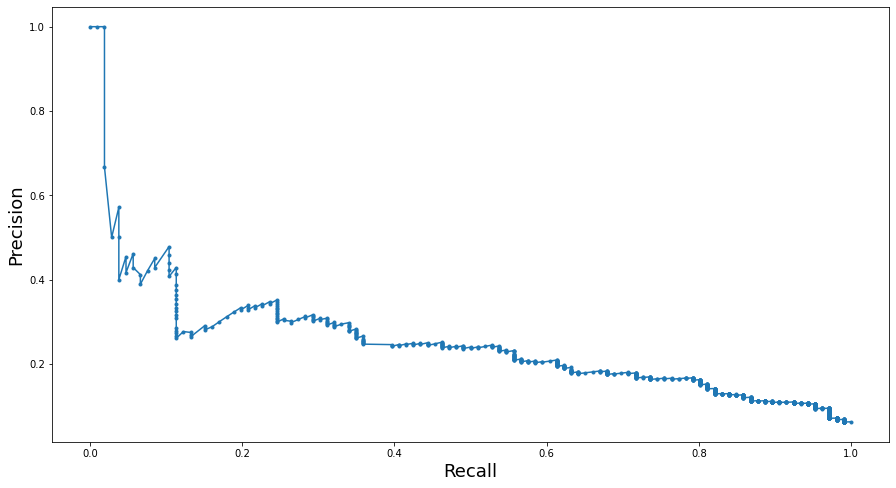

In [71]:
# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(y_test,rf_probability_gs)
# plot the model precision-recall curve
plt.figure(figsize=(15,8))
plt.plot(recall, precision, marker='.', label='Random Forest')
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.show()

### Model Evaluation & Selection

Let us compare the accuracy, precision and recall scores for models which have optimized parameters through cross-validation and GridSearch.

In [72]:
lr_cr = classification_report(y_test,lr_y_pred,output_dict=True)
knn_cr = classification_report(y_test,knn_y_pred,output_dict=True)
random_cr = classification_report(y_test,gs_y_pred,output_dict=True)

In [73]:
result =[['Baseline Model',baseline_accuracy, 'NA','NA','NA','NA','NA','NA','NA','NA'],
         ['Logistic Regression',lr_cr['accuracy'],lr_cr['0']['precision'],lr_cr['1']['precision'],lr_cr['0']['recall'],lr_cr['1']['recall'],lr_cr['0']['f1-score'],lr_cr['1']['f1-score'],roc_auc_score(y_test, lr_probability_gs),grid_lr.best_score_ ],
         ['KNN',lr_cr['accuracy'],knn_cr['0']['precision'],knn_cr['1']['precision'],knn_cr['0']['recall'],knn_cr['1']['recall'],knn_cr['0']['f1-score'],knn_cr['1']['f1-score'],roc_auc_score(y_test, knn_probability_gs),grid_knn.best_score_ ],
         ['Random Forest',random_cr['accuracy'],random_cr['0']['precision'],random_cr['1']['precision'],random_cr['0']['recall'],random_cr['1']['recall'],random_cr['0']['f1-score'],random_cr['1']['f1-score'],roc_auc_score(y_test, rf_probability_gs),grid_rf.best_score_ ]]
         
score = pd.DataFrame(result, columns=['Model', 'Accuracy Score','Precision: 0','Precision: 1','Recall: 0','Recall: 1','f1:0','f1:1','roc_auc score','cv train score'])
score

,Model,Accuracy Score,Precision: 0,Precision: 1,Recall: 0,Recall: 1,f1:0,f1:1,roc_auc score,cv train score
0,Baseline Model,0.947833,NA,NA,NA,NA,NA,NA,NA,NA
1,Logistic Regression,0.948039,0.948039,0,1,0,0.973327,0,0.837035,0.813948
2,KNN,0.948039,0.950739,0.6,0.997932,0.0566038,0.973764,0.103448,0.793314,0.756076
3,Random Forest,0.949020,0.94897,1,1,0.0188679,0.973817,0.037037,0.848986,0.834397


<ul>
<li>For all models, the accuracy performed comparable and marginally better than the baseline which is to be expected.</li>  
<li>Random Forest yields the highest accuracy but due to imbalance in positive and negative cases, other metrics should be examined.</li>
<li>KNN and Random Forest do a better job at precision and recall for the positive cases with KNN being more effective at positive recall while Random Forest performs better on overall precision.</li>
<li> Random Forest is the best model at distinguishing between positive class and negative class with roc_auc score of 0.82.
</li>
<li>Out of the 3 models, Random Forest also has highest cross-validation training score at 0.83 and is also deemed to generalize the best of all the models.</li>  
</ul>
<b>Random Forest will be selected as the classifier to perform the prediction the test set in view of its strong performances across various metrics, including the ability to better handle Type I & Type II errors and also having the highest AUC score.</b>

### Important Features generated by the Selected Random Forest Classifier

In [74]:
# Examining the important features of the random forest model
RF_Imp_Features = pd.DataFrame({'Features':X_train.columns,'Importance':best_rf.feature_importances_})
RF_Imp_Features.sort_values(by='Importance', ascending=False).head(10)

,Features,Importance
1,longitude,0.231175
0,latitude,0.179395
22,PrecipTotal_lag_14,0.044457
30,Aug,0.044378
21,Tavg_lag_14,0.036325
19,Tavg_lag_10,0.032645
7,dewpoint,0.028224
2,year,0.025359
15,resultdir,0.025208
4,tmax,0.023359


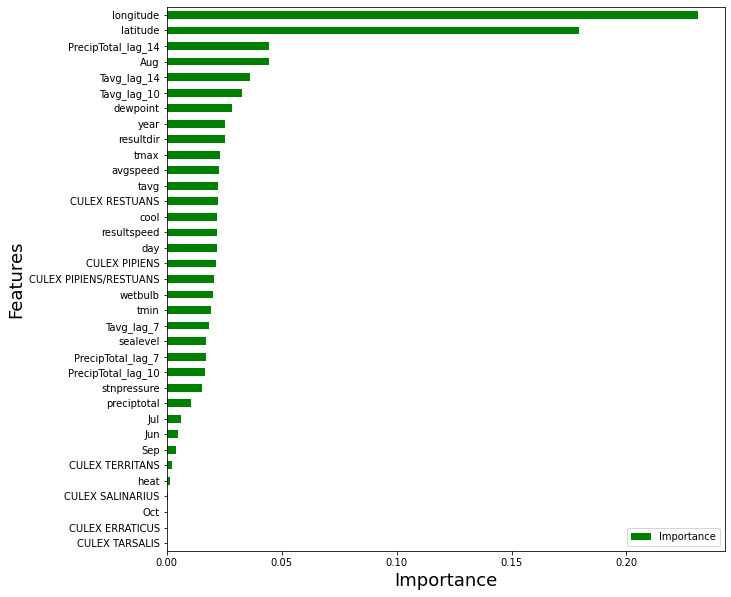

In [75]:
RF_Imp_Features.sort_values(by='Importance', inplace = True)
RF_Imp_Features.plot(kind = 'barh', x = 'Features', figsize = (10,10), color = 'green');
plt.xlabel('Importance', fontsize=18)
plt.ylabel('Features', fontsize=18)
plt.legend(loc = 'lower right', fontsize=10);

### Key Observations of Notable Features

<ul>
<li>Trap locations play a very strong role in classification model.The trap location coordinates appear to have the strongest influence due to the fact that certain areas would have a higher incidence of mosquitoes carrying the West Nile Virus. </li> 
<li>The amount of rainfall represented by the precipitation total (with a 14-day lag) was the next highest influencing factor. Stranding water resulting from rainfall are ideal breeding conditions for mosquitoes to lay their eggs.</li>
<li>The month of August seems to be identified as a noteworthy feature as it probably presents optimal seasonal conditions favourable for mosquito breeding</li>
<li>The average temperature (with a 10-14 lag) on the list, which takes into account the breeding lifecycle time, show that mosquitoes thrive and breed under interval-based temperature conditions.</li>  
<li>Dewpoint is also important given humidity is a necessary element for breeding.</li>
<li> It seems that certain years have prevalently more mosquitoes than other years. This could be due to the spraying events happening in later years resulting in a causative effect on the mosquito species and population distributions.
<li>Wind direction also seems to play a role since stronger winds are known to disrupt flight activities of the mosquitoes.</li>    
<li>One interesting observation is the notable presence of the 'CULEX RESTUAN' & 'CULEX_PIPIENS' combination mosquito species as an influencing feature. This could be due to the fact that the virus appears most frequently in these 2 particular breed of mosquitoes compared to the other types.</li>  
</ul>

## Predict the Test Results

In [109]:
# Load the final cleaned test set for prediction
dtest =pd.read_csv('./assets/test_final.csv')

# id column needs to be excluded from predictive model input and will be stored in a separate dataframe temporarily
id = pd.DataFrame(dtest['Id'].values)
dtest.drop('Id',axis=1,inplace=True)

dtest.head()

,date,species,trap,latitude,longitude,year,month,day,day_of_week,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,Tavg_lag_7,PrecipTotal_lag_7,Tavg_lag_10,PrecipTotal_lag_10,Tavg_lag_14,PrecipTotal_lag_14
0,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,2008,Jun,11,Wed,86.0,63.5,75.0,55.5,64.0,0.0,10.0,0.0,29.31,29.98,9.15,18.0,10.2,64.0,0.09,72.0,0.0,75.0,0.45
1,2008-06-11,CULEX RESTUANS,T002,41.95469,-87.800991,2008,Jun,11,Wed,86.0,63.5,75.0,55.5,64.0,0.0,10.0,0.0,29.31,29.98,9.15,18.0,10.2,64.0,0.09,72.0,0.0,75.0,0.45
2,2008-06-11,CULEX PIPIENS,T002,41.95469,-87.800991,2008,Jun,11,Wed,86.0,63.5,75.0,55.5,64.0,0.0,10.0,0.0,29.31,29.98,9.15,18.0,10.2,64.0,0.09,72.0,0.0,75.0,0.45
3,2008-06-11,CULEX SALINARIUS,T002,41.95469,-87.800991,2008,Jun,11,Wed,86.0,63.5,75.0,55.5,64.0,0.0,10.0,0.0,29.31,29.98,9.15,18.0,10.2,64.0,0.09,72.0,0.0,75.0,0.45
4,2008-06-11,CULEX TERRITANS,T002,41.95469,-87.800991,2008,Jun,11,Wed,86.0,63.5,75.0,55.5,64.0,0.0,10.0,0.0,29.31,29.98,9.15,18.0,10.2,64.0,0.09,72.0,0.0,75.0,0.45


In [110]:
id.head(5)

,0
0,1
1,2
2,3
3,4
4,5


### Perform feature engineering on test set

In [111]:
dtest = pd.concat([dtest,pd.get_dummies(dtest['species'], drop_first = False)], axis = 1)
dtest.drop('species', inplace=True, axis=1)

dtest.drop('date',axis=1,inplace=True)

#dtest = pd.concat([dtest,pd.get_dummies(dtest['day_of_week'], drop_first = True)], axis = 1)
dtest.drop('day_of_week', inplace=True, axis=1)

dtest = pd.concat([dtest,pd.get_dummies(dtest['month'], drop_first = False)], axis = 1)
dtest.drop('month', inplace=True, axis=1)

dtest.drop('trap', axis=1, inplace=True)

dtest.drop('UNSPECIFIED CULEX', axis=1, inplace=True)

### Check For Normalization on both the X_train and Test Set

In [112]:
dtest.head()

,latitude,longitude,year,day,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,Tavg_lag_7,PrecipTotal_lag_7,Tavg_lag_10,PrecipTotal_lag_10,Tavg_lag_14,PrecipTotal_lag_14,CULEX ERRATICUS,CULEX PIPIENS,CULEX PIPIENS/RESTUANS,CULEX RESTUANS,CULEX SALINARIUS,CULEX TARSALIS,CULEX TERRITANS,Aug,Jul,Jun,Oct,Sep
0,41.95469,-87.800991,2008,11,86.0,63.5,75.0,55.5,64.0,0.0,10.0,0.0,29.31,29.98,9.15,18.0,10.2,64.0,0.09,72.0,0.0,75.0,0.45,0,0,1,0,0,0,0,0,0,1,0,0
1,41.95469,-87.800991,2008,11,86.0,63.5,75.0,55.5,64.0,0.0,10.0,0.0,29.31,29.98,9.15,18.0,10.2,64.0,0.09,72.0,0.0,75.0,0.45,0,0,0,1,0,0,0,0,0,1,0,0
2,41.95469,-87.800991,2008,11,86.0,63.5,75.0,55.5,64.0,0.0,10.0,0.0,29.31,29.98,9.15,18.0,10.2,64.0,0.09,72.0,0.0,75.0,0.45,0,1,0,0,0,0,0,0,0,1,0,0
3,41.95469,-87.800991,2008,11,86.0,63.5,75.0,55.5,64.0,0.0,10.0,0.0,29.31,29.98,9.15,18.0,10.2,64.0,0.09,72.0,0.0,75.0,0.45,0,0,0,0,1,0,0,0,0,1,0,0
4,41.95469,-87.800991,2008,11,86.0,63.5,75.0,55.5,64.0,0.0,10.0,0.0,29.31,29.98,9.15,18.0,10.2,64.0,0.09,72.0,0.0,75.0,0.45,0,0,0,0,0,0,1,0,0,1,0,0


In [113]:
X_train.head()

,latitude,longitude,year,day,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,Tavg_lag_7,PrecipTotal_lag_7,Tavg_lag_10,PrecipTotal_lag_10,Tavg_lag_14,PrecipTotal_lag_14,CULEX ERRATICUS,CULEX PIPIENS,CULEX PIPIENS/RESTUANS,CULEX RESTUANS,CULEX SALINARIUS,CULEX TARSALIS,CULEX TERRITANS,Aug,Jul,Jun,Oct,Sep
4330,41.891118,-87.654491,2009,26,86.0,70.5,78.5,60.5,67.0,0.0,13.5,0.0000,29.20,29.840,6.40,4.0,8.10,65.0,0.00,54.0,0.00,52.0,0.000,0,0,0,1,0,0,0,0,0,1,0,0
1772,41.954690,-87.800991,2007,15,80.5,71.5,76.5,68.0,70.5,0.0,11.5,0.5300,29.20,29.880,4.15,6.5,6.45,73.0,0.93,79.0,0.28,80.0,0.005,0,0,1,0,0,0,0,1,0,0,0,0
8697,41.801498,-87.763416,2013,12,82.5,59.0,71.0,53.5,61.5,0.0,6.0,0.0000,29.41,30.095,4.05,8.0,5.10,68.0,1.30,74.0,0.00,76.0,0.000,0,0,0,1,0,0,0,0,1,0,0,0
8141,41.800737,-87.711880,2013,7,68.0,53.0,60.5,44.5,52.0,4.5,0.0,0.0025,29.23,29.920,9.15,2.5,9.55,54.0,0.00,58.0,0.00,50.0,0.140,0,0,0,1,0,0,0,0,0,1,0,0
4054,41.954690,-87.800991,2009,12,73.0,49.5,61.5,49.0,55.0,3.5,0.0,0.0050,29.27,29.950,4.70,6.5,6.25,50.0,0.00,63.0,0.12,50.0,0.000,0,0,1,0,0,0,0,0,0,1,0,0


In [114]:
dtest.shape

(116293, 35)

In [115]:
X_train.shape

(8158, 35)

In [116]:
# Scale test set
ss = StandardScaler()
ss.fit_transform(X_train)
dtest_ss = ss.transform(dtest)

In [117]:
# Predict the target variables on test set
dp_proba = best_rf.predict_proba(dtest_ss)
dp = [i[1] for i in dp_proba]

In [118]:
# Check that the values have been predicted
dp[0:10]

[0.04248973834991989,
 0.027923495485076156,
 0.035928294990263704,
 0.033896453063133346,
 0.030831300329747027,
 0.03323563829393424,
 0.03403320519988549,
 0.033839793037723324,
 0.04248973834991989,
 0.027923495485076156]

### Kaggle Submission

In [119]:
# Verify that the number of test results are correct
kaggle_result = pd.DataFrame(dp)

In [120]:
# Append back the Id labels
kaggle_result = pd.concat([id,pd.DataFrame(dp)],axis=1)

In [121]:
# Rename columns in accordance with submission requirements
kaggle_result.columns = ['Id','WnvPresent']

In [122]:
# Verify final integrity and format of the submission data
kaggle_result.head()

,Id,WnvPresent
0,1,0.042490
1,2,0.027923
2,3,0.035928
3,4,0.033896
4,5,0.030831


In [123]:
kaggle_result.tail()

,Id,WnvPresent
116288,116289,0.027773
116289,116290,0.026728
116290,116291,0.026674
116291,116292,0.027773
116292,116293,0.027773


In [124]:
kaggle_result.to_csv('./assets/kaggle_submission_v2.csv', index=False)